# Analyse Exploratoire du fichier myreport_swap_full.csv

### Imports (fichier & modules)

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

#import os
#print(os.getcwd())
#print(os.listdir('241016_LogETL'))

In [80]:
tab = pd.read_csv('../data/logServer/myreport_swap_full.csv', sep=',', dtype={'Program_Id': str, 'Schedules_Id': str, 'Schedules_Name': str})

### Le fichier myreport_swap_full.csv

In [81]:
print("il y a ",tab.shape[0]," lignes et ",tab.shape[1]," colonnes dans le data frame")

il y a  2882  lignes et  8  colonnes dans le data frame


In [82]:
tab.columns

Index(['Date et heure', 'Date et heure(RAW)', 'Total', 'Total(RAW)',
       'Temps mort', 'Temps mort(RAW)', 'Couverture', 'Couverture(RAW)'],
      dtype='object')

In [83]:
tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2882 entries, 0 to 2881
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date et heure       2882 non-null   object 
 1   Date et heure(RAW)  2881 non-null   float64
 2   Total               2195 non-null   object 
 3   Total(RAW)          2194 non-null   float64
 4   Temps mort          2195 non-null   object 
 5   Temps mort(RAW)     2194 non-null   float64
 6   Couverture          2882 non-null   object 
 7   Couverture(RAW)     2881 non-null   float64
dtypes: float64(4), object(4)
memory usage: 180.3+ KB


In [84]:
# Calculer le nombre de valeurs uniques pour chaque colonne
nb_valeurs_uniques = tab.nunique()

# Afficher les résultats
print(nb_valeurs_uniques)

Date et heure         2882
Date et heure(RAW)    2881
Total                    7
Total(RAW)              28
Temps mort               1
Temps mort(RAW)          1
Couverture               3
Couverture(RAW)          2
dtype: int64


In [85]:
tab.head()


,Date et heure,Date et heure(RAW),Total,Total(RAW),Temps mort,Temps mort(RAW),Couverture,Couverture(RAW)
0,13/08/2024 00:00:00 - 01:00:00,45516.958333,NaN,NaN,NaN,NaN,0 %,0.0
1,13/08/2024 01:00:00 - 02:00:00,45517.000000,NaN,NaN,NaN,NaN,0 %,0.0
2,13/08/2024 02:00:00 - 03:00:00,45517.041667,3 %,3.0,0 %,0.0,100 %,10000.0
3,13/08/2024 03:00:00 - 04:00:00,45517.083333,3 %,3.0,0 %,0.0,100 %,10000.0
4,13/08/2024 04:00:00 - 05:00:00,45517.125000,3 %,3.0,0 %,0.0,100 %,10000.0


### Suppression des valeurs NaN

In [86]:
num_deleted = tab.shape[0]
tab.dropna(inplace=True)
num_deleted -= tab.shape[0]

print(f"Number of rows deleted: {num_deleted}")

Number of rows deleted: 688


### Transformation des dates

In [87]:
from datetime import datetime, timedelta

def from_excel_ordinal(ordinal, epoch=datetime(1900, 1, 1)):
    # Adapted from above, thanks to @Martijn Pieters 

    if ordinal > 59:
        ordinal -= 1  # Excel leap year bug, 1900 is not a leap year!
    inDays = int(ordinal)
    frac = ordinal - inDays
    inSecs = int(round(frac * 86400.0))

    return epoch + timedelta(days=inDays - 1, seconds=inSecs) # epoch is day 1

excelDT = 42548.75001           # Float representation of 27/06/2016  6:00:01 PM in Excel format  
pyDT = from_excel_ordinal(excelDT)
print(pyDT)

2016-06-27 18:00:01


In [88]:
# Convertir toutes les dates de la colonne 'Date et heure(RAW)'
tab['date_full'] = tab['Date et heure(RAW)'].apply(from_excel_ordinal)

# Extraire la date et l'heure sous forme de colonnes séparées
tab['date'] = tab['date_full'].dt.strftime("%Y-%m-%d")  # Format YY-MM-DD
tab['heure'] = tab['date_full'].dt.strftime("%H")  # Format HH

In [89]:
tab.head()


,Date et heure,Date et heure(RAW),Total,Total(RAW),Temps mort,Temps mort(RAW),Couverture,Couverture(RAW),date_full,date,heure
2,13/08/2024 02:00:00 - 03:00:00,45517.041667,3 %,3.0,0 %,0.0,100 %,10000.0,2024-08-13 01:00:00,2024-08-13,01
3,13/08/2024 03:00:00 - 04:00:00,45517.083333,3 %,3.0,0 %,0.0,100 %,10000.0,2024-08-13 02:00:00,2024-08-13,02
4,13/08/2024 04:00:00 - 05:00:00,45517.125000,3 %,3.0,0 %,0.0,100 %,10000.0,2024-08-13 03:00:00,2024-08-13,03
5,13/08/2024 05:00:00 - 06:00:00,45517.166667,3 %,3.0,0 %,0.0,100 %,10000.0,2024-08-13 04:00:00,2024-08-13,04
6,13/08/2024 06:00:00 - 07:00:00,45517.208333,3 %,3.0,0 %,0.0,100 %,10000.0,2024-08-13 05:00:00,2024-08-13,05


In [90]:
# déplacement des nouvelles colonnes de date/heure à gauche
cols = tab.columns  # Liste des colonnes
tab = tab[cols[-3:].tolist() + cols[:-3].tolist()]

In [91]:
# renommage des colonnes
tab.rename(columns={"Temps du ping(RAW)": "Temps du ping(ms)"}, inplace=True)
tab.rename(columns={"Minimum(RAW)": "Minimum(ms)"}, inplace=True)
tab.rename(columns={"Maximum(RAW)": "Maximum(ms)"}, inplace=True)
tab.rename(columns={"Perte de paquets(RAW)": "Perte de paquets(%)"}, inplace=True)
tab.rename(columns={"Couverture(RAW)": "Couverture(%)"}, inplace=True)
tab.rename(columns={"Total(RAW)": "swap(%)"}, inplace=True)

# suppression des colonnes inutiles
tab = tab.drop(columns=["Temps mort(RAW)"])
tab = tab.drop(columns=["Date et heure"])
tab = tab.drop(columns=["Total"])
tab = tab.drop(columns=["Temps mort"])
tab = tab.drop(columns=["Couverture"])


In [92]:
tab.head()


,date_full,date,heure,Date et heure(RAW),swap(%),Couverture(%)
2,2024-08-13 01:00:00,2024-08-13,01,45517.041667,3.0,10000.0
3,2024-08-13 02:00:00,2024-08-13,02,45517.083333,3.0,10000.0
4,2024-08-13 03:00:00,2024-08-13,03,45517.125000,3.0,10000.0
5,2024-08-13 04:00:00,2024-08-13,04,45517.166667,3.0,10000.0
6,2024-08-13 05:00:00,2024-08-13,05,45517.208333,3.0,10000.0


In [93]:
print(type(tab["date_full"].iloc[0])) #vérifier le typage de date_full

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Analyse temporelle

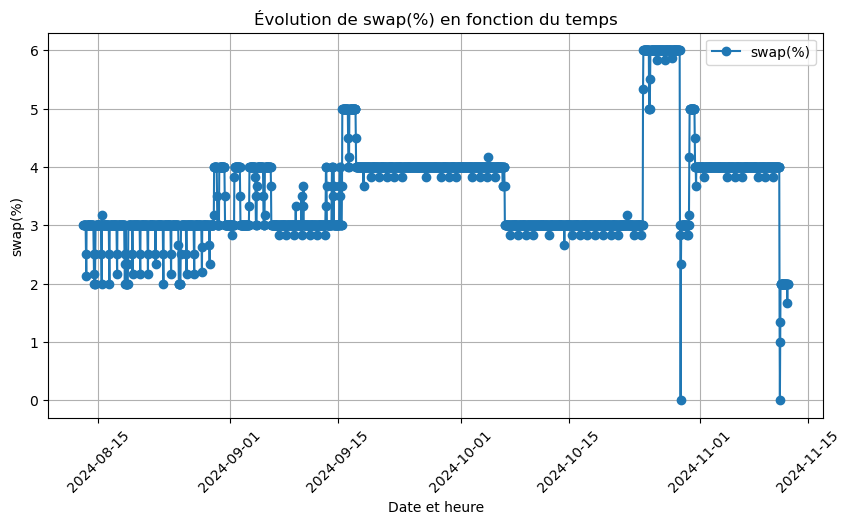

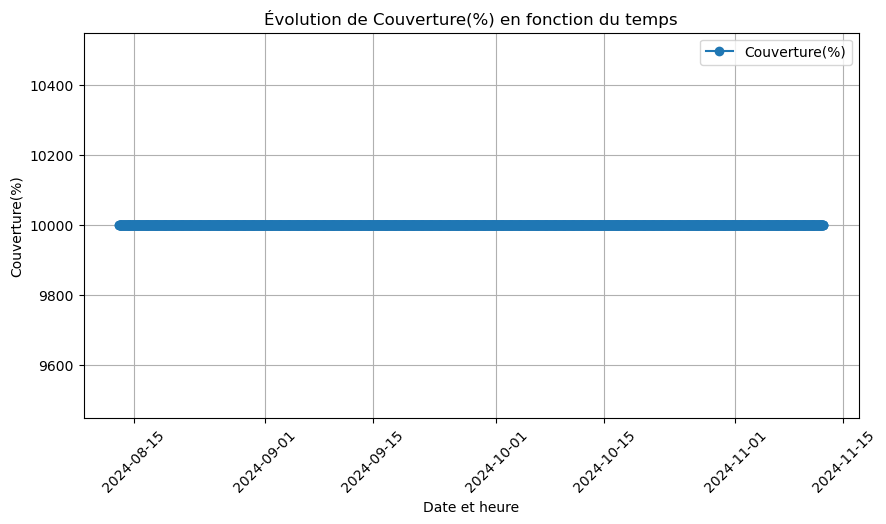

In [94]:
import matplotlib.pyplot as plt
import itertools
import pandas as pd

import matplotlib.pyplot as plt

# Vérifier que 'date_full' est bien au format datetime
tab["date_full"] = pd.to_datetime(tab["date_full"])

# Liste des colonnes à exclure
excluded_cols = ["date_full", "date", "heure", "Date et heure(RAW)"]

# Tracer chaque colonne en fonction du temps
for col in tab.columns:
    if col not in excluded_cols:  # Exclure les colonnes non pertinentes
        plt.figure(figsize=(10, 5))

        plt.plot(tab["date_full"], tab[col], marker='o', linestyle='-')

        plt.xlabel("Date et heure")
        plt.ylabel(f"{col}")  # Correction de la syntaxe
        plt.title(f"Évolution de {col} en fonction du temps")
        plt.legend([col])  # Correction de la légende
        plt.xticks(rotation=45)
        plt.grid()

        plt.show()

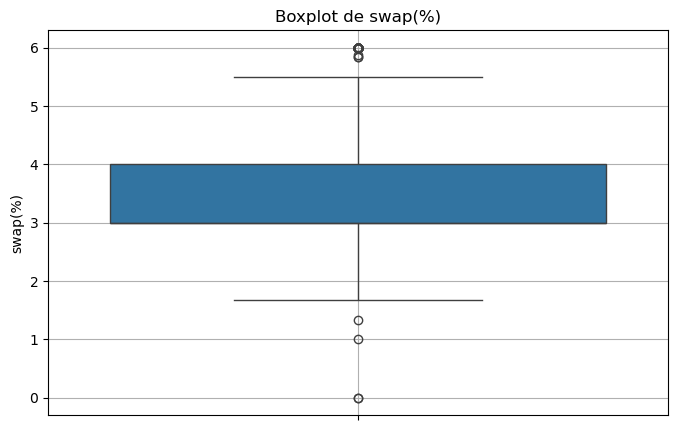

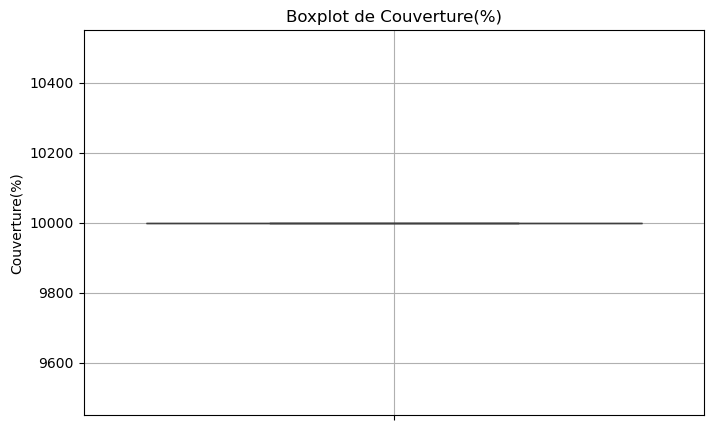

In [95]:
import seaborn as sns

# Exclure les colonnes non numériques
numerical_cols = tab.select_dtypes(include=['number']).columns

# Tracer un boxplot pour chaque colonne
for col in numerical_cols:
    if col not in excluded_cols:  # Exclure les colonnes non pertinentes
        plt.figure(figsize=(8, 5))
        sns.boxplot(y=tab[col])
        plt.title(f"Boxplot de {col}")
        plt.grid()
        plt.show()

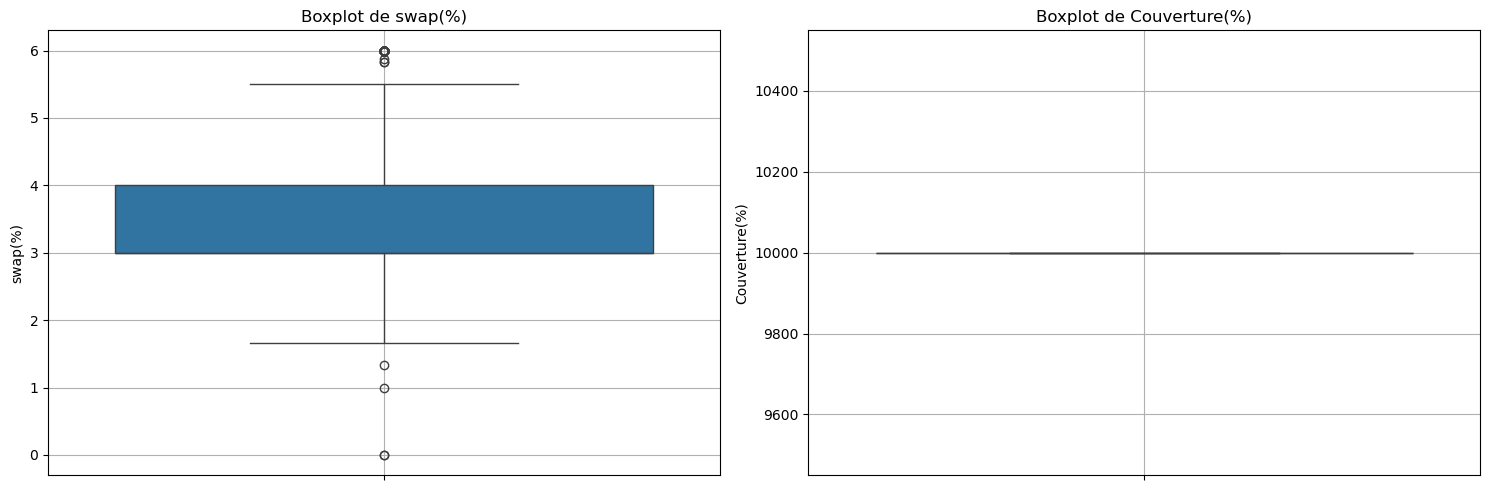

In [96]:
import math

# Sélection des colonnes numériques
numerical_cols = tab.select_dtypes(include=['number']).columns

# Filtre pour exclure les colonnes non pertinentes
cols_to_plot = [col for col in numerical_cols if col not in excluded_cols]

rows=(math.ceil(len(cols_to_plot)/3))
# Créer une figure avec 2 lignes et 3 colonnes de sous-graphiques (axes)
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(15, rows*5))

# Convertir "axes" en un tableau 1D pour plus de flexibilité
axes = axes.flatten()

# Boucler sur les colonnes et tracer un boxplot dans chaque sous-graphique
for i, col in enumerate(cols_to_plot):
    sns.boxplot(y=tab[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")
    axes[i].grid()

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher la figure
plt.show()

### Enregistrement du nouveau dataframe dans un nouveau csv

In [97]:
#### ATTENTION au path et nom de fichier
tab.to_csv("../data/logServer/filtered/myreport_ping_full.csv", index=False, encoding='utf-8')

### Obsolete

In [98]:
df=tab.copy()

# Boucle pour générer les graphiques
for col in df.columns:
    if col != 'Date et heure(RAW)' and "RAW" in col:  # Exclure la colonne 'Date et heure(RAW)'
        plt.figure(figsize=(10, 6))
        df[col].plot(kind='line', title=f'Évolution de : {col}')
        plt.xlabel('Date et heure')
        plt.ylabel(col)
        plt.grid(True)
        plt.tight_layout()
        plt.show()